In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import norm


**Functions**

**Edge Weight Prediction in Weighted Signed Networks** 

Site : https://cs.stanford.edu/~srijan/wsn/

In [9]:
'''
Code for the paper:
Edge Weight Prediction in Weighted Signed Networks. 
Conference: ICDM 2016
Authors: Srijan Kumar, Francesca Spezzano, VS Subrahmanian and Christos Faloutsos

Author of code: Srijan Kumar
Email of code author: srijan@cs.stanford.edu
'''

import math

def initiliaze_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='rate')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness

def compute_fairness_goodness(G):
    fairness, goodness = initiliaze_scores(G)
    
    nodes = G.nodes()
    iter = 0
    while iter < 100:
        df = 0
        dg = 0

        # print ('-----------------')
        # print ("Iteration number", iter)
        
        # print ('Updating goodness')
        for node in nodes:
            #print(node)
            inedges = G.in_edges(node, data='rate')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        #print ('Updating fairness')
        for node in nodes:
            outedges = G.out_edges(node, data='rate')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        #print ('Differences in fairness score and goodness score = %.2f, %.2f' % (df, dg))
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    
    return fairness, goodness


In [10]:
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

**Data Preprocessing**

In [11]:
trustNetwork = pd.read_csv("soc-sign-bitcoinalpha.csv.gz", compression="gzip", names=["source", "target", "rate", "time"])
trustNetwork.head()

,source,target,rate,time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400


In [12]:
#The weight should already be in the range of [-1, 1] of the FGA
trustNetwork['rate']= MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(trustNetwork['rate']).reshape(-1, 1))


In [13]:
#Using directed graph and pass the rate as edge weights 
trustGraph = nx.from_pandas_edgelist(trustNetwork, "source", "target", "rate", create_using=nx.DiGraph())

Visualization

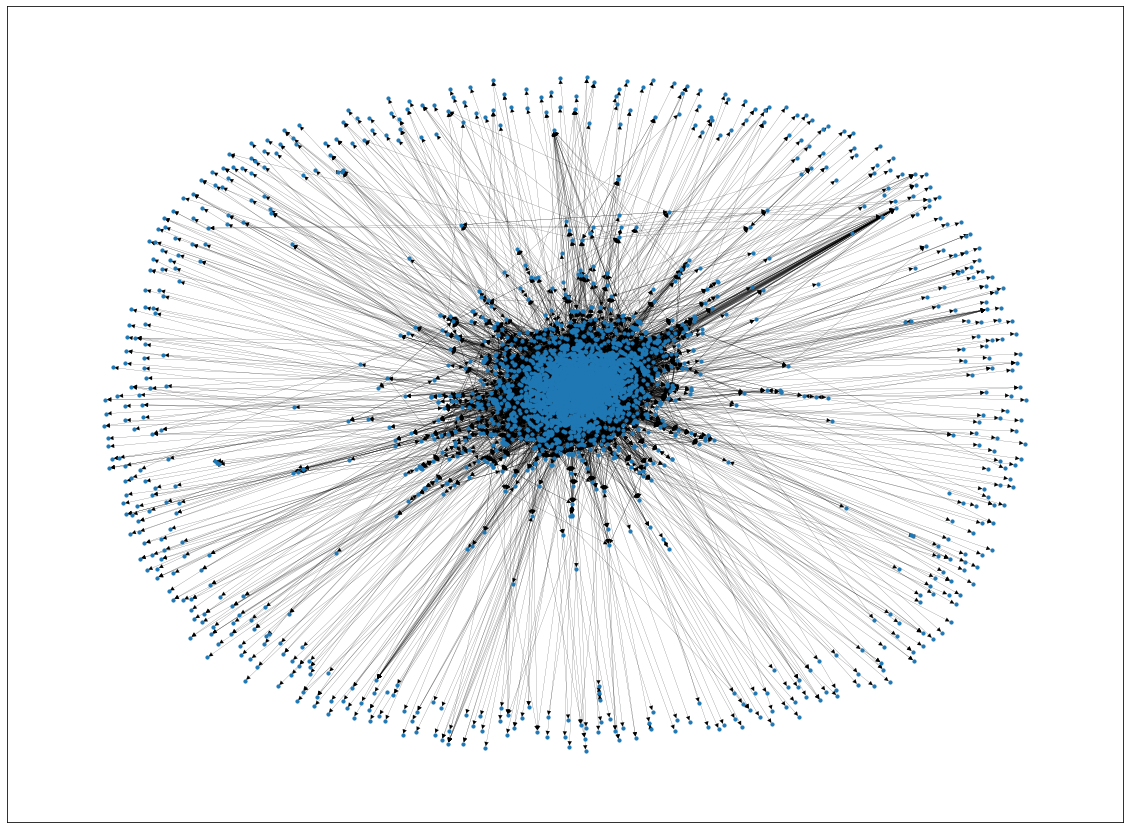

In [14]:
pos=nx.spring_layout(trustGraph)
fig, ax=plt.subplots(figsize= (20, 15))
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(trustGraph, pos=pos, ax=ax, **plot_options)

In [15]:
print("Number of Nodes: {}".format(trustGraph.number_of_nodes()))
print("Number of Edges: {}".format(trustGraph.number_of_edges()))
print("Graph density: {}".format(nx.density(trustGraph)))

Number of Nodes: 3783
Number of Edges: 24186
Graph density: 0.0016904649973936393


In [16]:
fairness, goodness = compute_fairness_goodness(trustGraph)

In [17]:
print("Fairness mean {} ".format(np.array(list(fairness.values())).mean()))

Fairness mean 0.9424351096233645 


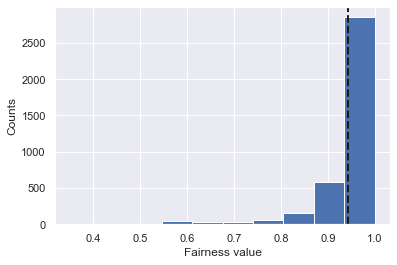

In [18]:
sns.set()
_=plt.hist(fairness.values())
_= plt.xlabel("Fairness value")
_= plt.ylabel("Counts")
plt.axvline(np.array(list(fairness.values())).mean(), color='k', linestyle='dashed', linewidth=2 )

plt.show()

(-1.130002763569355,
 1.1886430647969246,
 -1.2009570485353471,
 1.1148337012529375)

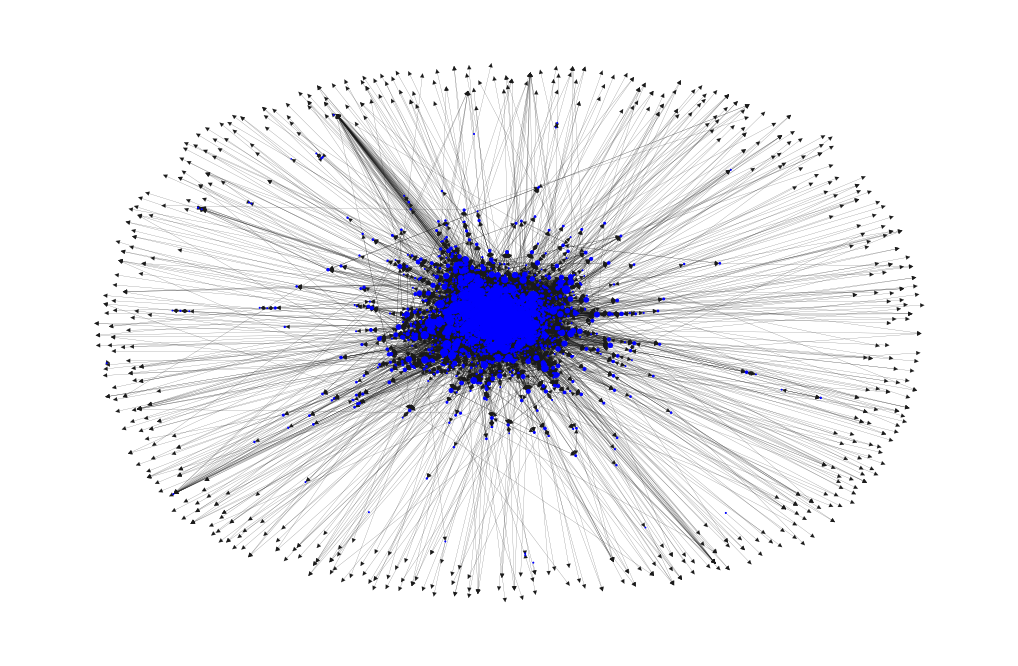

In [19]:
pos=nx.spring_layout(trustGraph)
node_size = [(v*trustGraph.out_degree(l)) for l, v in fairness.items()]  
plt.figure(figsize=(18, 12))
nx.draw_networkx(trustGraph, pos=pos, node_size=node_size, with_labels=False, width=0.15, node_color= "blue" )
plt.axis("off")

In [20]:
print("Goodness mean {} ".format(np.array(list(goodness.values())).mean()))


Goodness mean 0.11825600878727517 


In [21]:
(sorted(goodness.items(), key=lambda item: item[1], reverse=True))[:10]

[(795, 0.9937443255477516),
 (834, 0.9929820258746779),
 (776, 0.9851508939705974),
 (820, 0.9774126141808581),
 (797, 0.9764135799191066),
 (833, 0.9722620803924772),
 (791, 0.9513495840355346),
 (837, 0.9480676217851342),
 (835, 0.9480676217851342),
 (808, 0.9457056975126594)]

c:\Users\Compu Store\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\Compu Store\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\drawing\nx_pylab.py:728: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(marker_size) / 2


(-1.130002763569355,
 1.1886430647969246,
 -1.2009570485353471,
 1.1148337012529375)

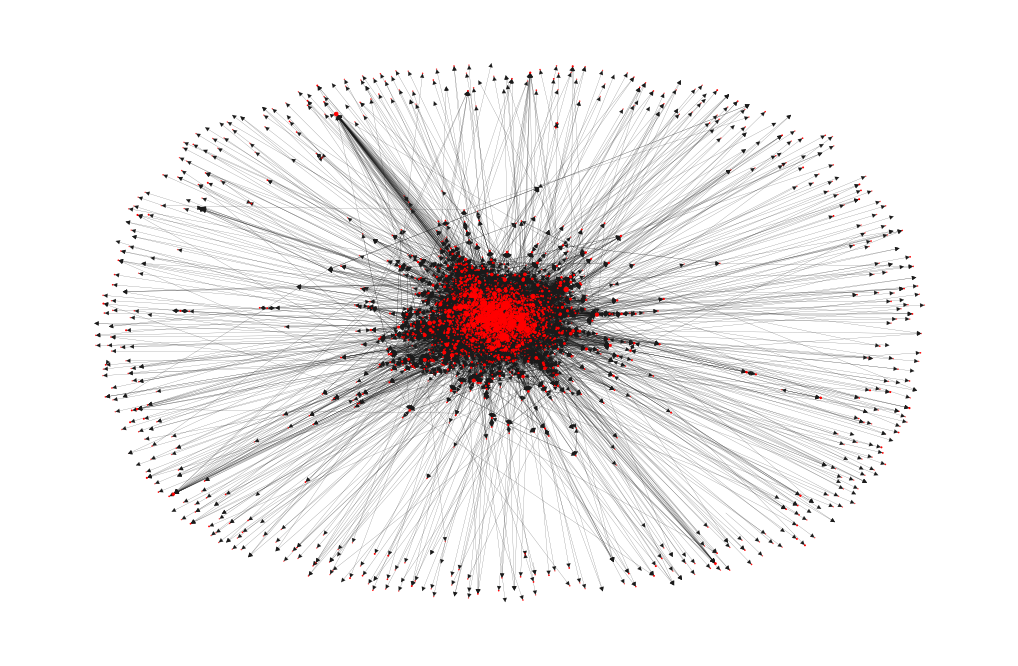

In [22]:
node_size = [(v*trustGraph.in_degree(l)) for l, v in goodness.items()]  
plt.figure(figsize=(18, 12))
nx.draw_networkx(trustGraph, pos=pos, node_size=node_size, with_labels=False, width=0.15, node_color= "red" )
plt.axis("off")

<function matplotlib.pyplot.show(close=None, block=None)>

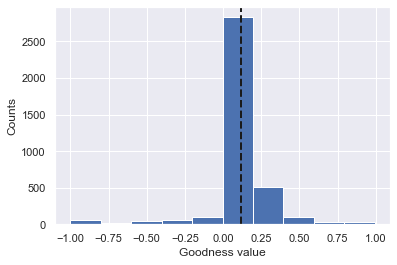

In [23]:
sns.set()
_ = plt.hist(goodness.values())
_ = plt.xlabel("Goodness value")
_ = plt.ylabel("Counts")
plt.axvline(np.array(list(goodness.values())).mean(), color='k', linestyle='dashed', linewidth=2 )
plt.show

In [24]:
degree=[d for _, d in trustGraph.degree]


<function matplotlib.pyplot.show(close=None, block=None)>

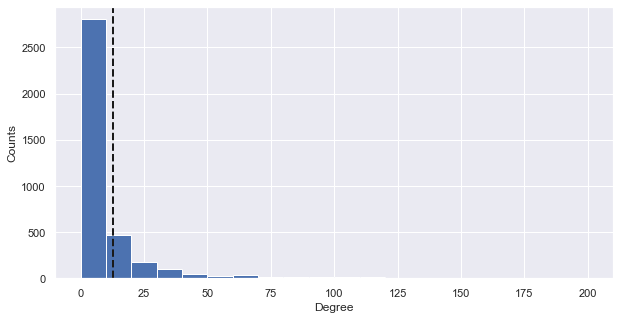

In [25]:
sns.set()
plt.figure(figsize=(10,5)),
_ = plt.hist(degree, bins=20, range=(0,200))
_ = plt.xlabel("Degree")
_ = plt.ylabel("Counts")
plt.axvline(np.array(degree).mean(), color='k', linestyle='dashed', linewidth=2 )
plt.show

Centrality Measure

Centrality measure 
As fairness has the out-degree as a parameter in the equation


In [26]:
out_degree_centrality = nx.centrality.out_degree_centrality(trustGraph)  
out_degree_centrality_10= (sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
out_degree_centrality_10

[(1, 0.12956107879428874),
 (8, 0.06848228450555262),
 (3, 0.06425171866737175),
 (4, 0.05684822845055526),
 (7, 0.05605499735589635),
 (11, 0.053675304071919616),
 (177, 0.053410893707033315),
 (15, 0.0520888418826018),
 (2, 0.05156002115282919),
 (10, 0.046800634584875725)]

In [27]:
[fairness[out_degree_centrality_10[n][0]] for n in range(len(out_degree_centrality_10))]

[0.9822441794086626,
 0.9315244647690797,
 0.9486327394347916,
 0.9443534869647418,
 0.9123999448382141,
 0.9140323951289959,
 0.9143399038770686,
 0.9148478246489942,
 0.9212536437878205,
 0.9461612242421493]

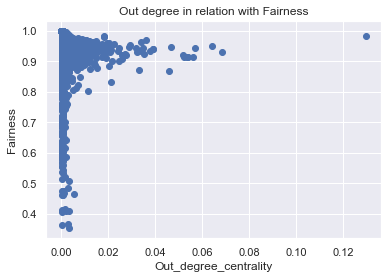

In [28]:
sns.set()
plt.scatter(out_degree_centrality.values(), fairness.values())
plt.xlabel("Out_degree_centrality")
plt.ylabel("Fairness")
plt.title("Out degree in relation with Fairness")
plt.show()

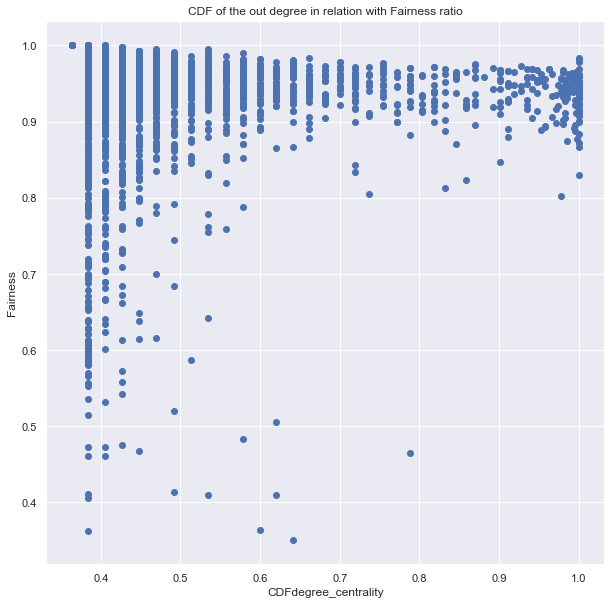

In [29]:
CDFdegree_centrality = normcdf(np.array(list(out_degree_centrality.values())))
plt.figure(figsize=(10, 10))
plt.scatter(CDFdegree_centrality, fairness.values())
plt.xlabel("CDFdegree_centrality")
plt.ylabel("Fairness")
plt.title("CDF of the out degree in relation with Fairness ratio")

plt.show()

When degree of Centrality is high, Fairness is high but not VicaVersa


In [30]:
in_degree_centrality = nx.centrality.in_degree_centrality(trustGraph)  
in_degree_centrality_10= (sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
in_degree_centrality_10

[(1, 0.10523532522474881),
 (3, 0.0663670015864622),
 (2, 0.054204124801692226),
 (11, 0.053675304071919616),
 (4, 0.05314648334214701),
 (177, 0.0523532522474881),
 (7, 0.05156002115282919),
 (10, 0.04336329984135378),
 (5, 0.03860391327340032),
 (6, 0.03675304071919619)]

In [31]:
[goodness[in_degree_centrality_10[n][0]] for n in range(len(in_degree_centrality_10))]

[0.17517626437834855,
 0.22377711801712385,
 0.3300283138966492,
 0.12835526189865853,
 0.27336107939260146,
 0.03819284240972416,
 0.18881132790173263,
 0.16543795810554152,
 0.2517739969838676,
 0.25505077345245203]

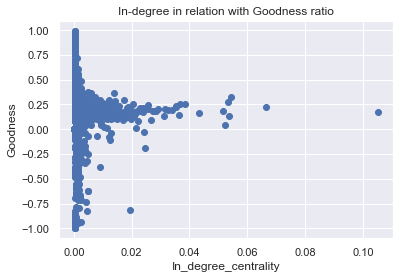

In [32]:
sns.set()
plt.scatter(in_degree_centrality.values(), goodness.values())
plt.xlabel("In_degree_centrality")
plt.ylabel("Goodness")
plt.title("In-degree in relation with Goodness ratio")
plt.show()

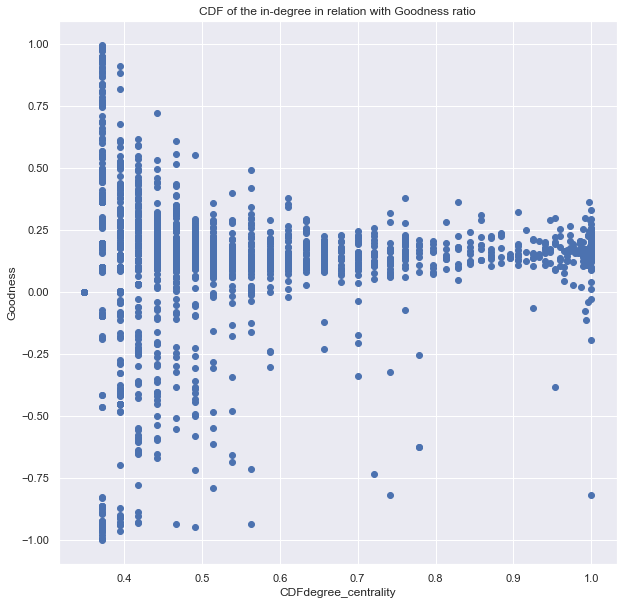

In [33]:
CDFdegree_centrality = normcdf(np.array(list(in_degree_centrality.values())))
plt.figure(figsize=(10, 10))
plt.scatter(CDFdegree_centrality, goodness.values())
plt.xlabel("CDFdegree_centrality")
plt.ylabel("Goodness")
plt.title("CDF of the in-degree in relation with Goodness ratio")

plt.show()

Also after a threshold of out_degree centrality it can be considerable as a good node

In [34]:
betweenness_centrality=nx.centrality.betweenness_centrality(trustGraph)
betweenness_centrality_10 = sorted(betweenness_centrality.items(), key=lambda item:item[1], reverse=True)[:10]
betweenness_centrality_10

[(1, 0.149156117120169),
 (2, 0.06245174844052738),
 (4, 0.05919549891068014),
 (11, 0.05078417339751049),
 (3, 0.04774969061925636),
 (10, 0.04290572353819755),
 (15, 0.041211188672576296),
 (8, 0.036039514608922955),
 (13, 0.036019086718434644),
 (177, 0.03516179796601332)]

In [35]:
[fairness[betweenness_centrality_10[n][0]] for n in range(len(betweenness_centrality_10))]

[0.9822441794086626,
 0.9212536437878205,
 0.9443534869647418,
 0.9140323951289959,
 0.9486327394347916,
 0.9461612242421493,
 0.9148478246489942,
 0.9315244647690797,
 0.9337990123887331,
 0.9143399038770686]

In [36]:
[goodness[betweenness_centrality_10[n][0]] for n in range(len(betweenness_centrality_10))]

[0.17517626437834855,
 0.3300283138966492,
 0.27336107939260146,
 0.12835526189865853,
 0.22377711801712385,
 0.16543795810554152,
 0.18922545773985025,
 0.23491515519730644,
 0.2073161354896028,
 0.03819284240972416]

In [37]:
closeness_centrality=nx.centrality.closeness_centrality(trustGraph)
closeness_centrality_10 = sorted(closeness_centrality.items(), key=lambda item:item[1], reverse=True)[:10]
closeness_centrality_10

[(2, 0.36679457392726394),
 (11, 0.36526606417786006),
 (1, 0.3587718223102824),
 (10, 0.3529036369931791),
 (4, 0.34615304292506327),
 (42, 0.34126756379386636),
 (3, 0.34023266700895044),
 (9, 0.3399028243846082),
 (26, 0.3383855841261657),
 (95, 0.3372463757150159)]

In [38]:
[fairness[closeness_centrality_10[n][0]] for n in range(len(closeness_centrality_10))]

[0.9212536437878205,
 0.9140323951289959,
 0.9822441794086626,
 0.9461612242421493,
 0.9443534869647418,
 0.9375952287885723,
 0.9486327394347916,
 0.9322464344224686,
 0.9240575312913095,
 0.9316970318643798]

In [39]:
[goodness[closeness_centrality_10[n][0]] for n in range(len(closeness_centrality_10))]

[0.3300283138966492,
 0.12835526189865853,
 0.17517626437834855,
 0.16543795810554152,
 0.27336107939260146,
 0.15476016521079802,
 0.22377711801712385,
 0.2271364829316883,
 0.13862249053373452,
 0.09461855241857627]

In [40]:
PageRank  = nx.pagerank(trustGraph)
PageRank_10 = sorted(PageRank.items(), key=lambda item:item[1], reverse=True)[:10]
PageRank_10

[(1, 0.01699309922840529),
 (3, 0.008960320960927018),
 (4, 0.008023439583332511),
 (2, 0.006623183283223336),
 (177, 0.006607811108334513),
 (7, 0.006543114032848891),
 (11, 0.006192044052141411),
 (10, 0.005598872299087017),
 (13, 0.005287958636203424),
 (6, 0.004780121390485107)]

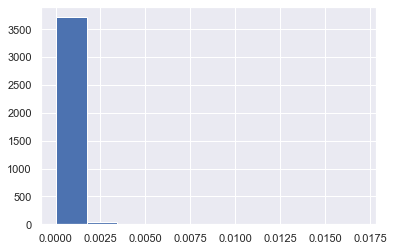

In [41]:
plt.hist(PageRank.values())
plt.show()

In [42]:
[fairness[PageRank_10[n][0]] for n in range(len(PageRank_10))]

[0.9822441794086626,
 0.9486327394347916,
 0.9443534869647418,
 0.9212536437878205,
 0.9143399038770686,
 0.9123999448382141,
 0.9140323951289959,
 0.9461612242421493,
 0.9337990123887331,
 0.941087391910087]

In [43]:
[goodness[PageRank_10[n][0]] for n in range(len(PageRank_10))]

[0.17517626437834855,
 0.22377711801712385,
 0.27336107939260146,
 0.3300283138966492,
 0.03819284240972416,
 0.18881132790173263,
 0.12835526189865853,
 0.16543795810554152,
 0.2073161354896028,
 0.25505077345245203]